In [1]:
using CSV
using JLD
using Random
using PhyloPlots
using DataFrames
using SparseArrays
using Distributions
using Combinatorics
using PhyloNetworks
using PhyloCoalSimulations
using MLBase
using Hungarian
using LinearAlgebra
using ParallelKMeans

In [2]:
function num_bipartitions(n)
    return 2^(n-1) - 1
end;

function get_nodes(idx)
    nodes = []
    for i in 1:length(idx)
        if idx[i]
            append!(nodes, i)
        end
    end
    return nodes
end


function get_bipartition(tree, n)
    taxa = sort(tipLabels(tree))
    if length(taxa) != n
        print("check the parameter n")
        return
    end
    node = Vector(1:n)
    result = []
    idx = 0
    for i in tree.edge
        node_idx = hardwiredCluster(i,taxa)
        branch_node = get_nodes(node_idx)
        
        # if branch seperates more than half nodes, we use the small part to get bipartition idx
        if (length(branch_node) > n ÷ 2)
             branch_node = sort(collect(setdiff(node,branch_node)))
        end
        
        # generate all possible combination with the same number of nodes
        comb = collect(combinations(Vector(1:n), length(branch_node)))
        for c in 1:length(comb)
            if comb[c] == branch_node
                # if the combination is the later, we need to find its first half
                if length(branch_node) > 1 && c > length(comb) ÷ 2
                    c = length(comb) - c + 1 
                end
                idx = c - 1
                break
            end
        end
        for j in 1:(length(branch_node) - 1)
            idx = idx + binomial(n,j)
        end
        push!(result,Pair(idx, i.length))
        idx = 0
    end
    return result
end;

function print_bipartition(trees, n)
    
    # build the table
    N = num_bipartitions(n)
    data = zeros(length(trees), N)
    treeNum = 1;
    # get existing index
    
    for i in trees
        bipart = get_bipartition(i, n)
        for j in 1:length(bipart)
            data[treeNum,(bipart[j][1] + 1)] += bipart[j][2]
        end
        treeNum+=1
    end
    return data
end;

function simulate_trees(tree, target, i)
    d = Uniform(0.5, 2)
    Random.seed!(123 + i)
    n = length(tree.edge)

    x = rand(d, n)
    idx = 1
    for e in tree.edge
        e.length += x[idx]
        e.length = round(e.length, digits = 2)
        idx += 1
    end

    tree = simulatecoalescent(tree, 50, 1)
    tree = print_bipartition(tree, 8)
    tree = sparse(tree)
    jldopen(target, "w") do file
        write(file, "tree", tree)
    end
end;

In [3]:
function ground_true(df_1, df_2)
    a = fill(1,size(df_1)[1])
    b = fill(2,size(df_2)[1])
    gt = cat(a,b, dims = 1)
    return gt
end

# convert tree from dataframe to matrix. Each column is a tree
function standardize_tree(tree)    
    data = collect(Matrix(tree)');
    
    # standardize tree
    dt = fit(ZScoreTransform, data, dims=2)
    data = StatsBase.transform(dt, data)
    
    # replace NaN value with 0
    replace!(data, NaN=>0)
    return data
end

function plot_clusters(tree, label)
    PCA_model = fit(PCA, tree, maxoutdim = 2);
    PCA_data = predict(PCA_model,tree)
    scatter(PCA_data[1,:], PCA_data[2,:], markersize = 5, color = label)
end

function accuracy(n, gt, pred)
    matrix = confusmat(n, gt, pred)
    # Hungarian algorithm minimizes the cost, so we need to transform the matrix
    A = -matrix .+ maximum(matrix)    
    matrix = matrix[:,hungarian(A)[1]]
    x = tr(matrix)/sum(matrix)
    return matrix, x
end

# Kmeans
function kmeans_label(tree, n; seed =:"k-means++")  
    result = kmeans(tree, n; k_init ="k-means++");
    return result.assignments
end

kmeans_label (generic function with 1 method)

In [4]:
Random.seed!(3);
base = "((((6:0.0,7:0.0):0.0,(4:0.0,2:0.0):0.0):0.0,(8:0.0,(5:0.0,3:0.0):0.0):0.0):0.0,1:0.0);"

base_tree = readTopology(base);
nni!(base_tree, base_tree.edge[3], true, true);
tree1 = writeTopology(base_tree)
nni!(base_tree, base_tree.edge[11], true, true);
tree2 = writeTopology(base_tree)
nni!(base_tree, base_tree.edge[12], true, true);
tree3 = writeTopology(base_tree)
nni!(base_tree, base_tree.edge[6], true, true);
tree4 = writeTopology(base_tree)
nni!(base_tree, base_tree.edge[3], true, true);
tree5 = writeTopology(base_tree)

"(((5:0.0,8:0.0):0.0,(3:0.0,((7:0.0,2:0.0):0.0,(6:0.0,4:0.0):0.0):0.0):0.0):0.0,1:0.0);"

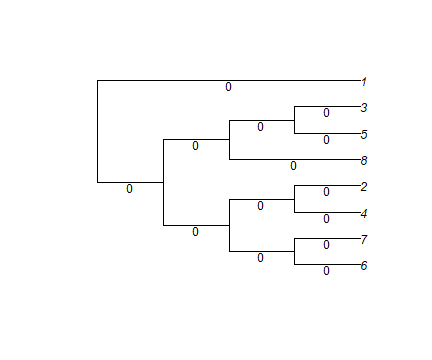

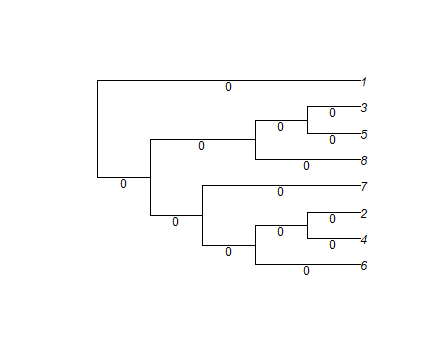

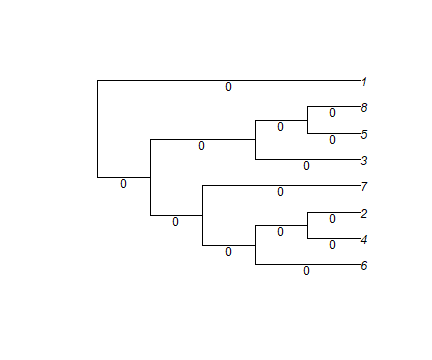

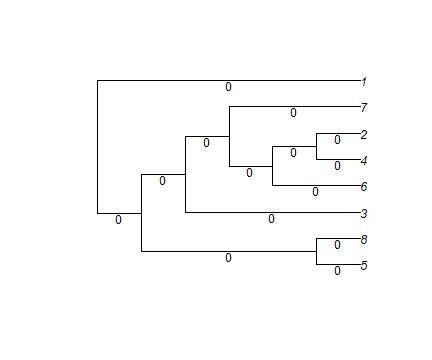

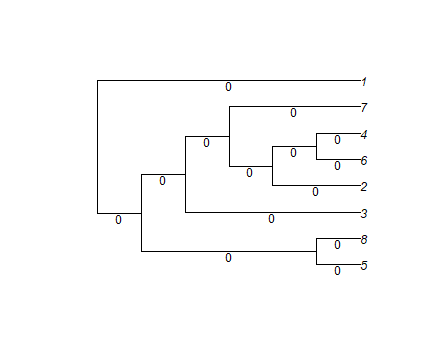

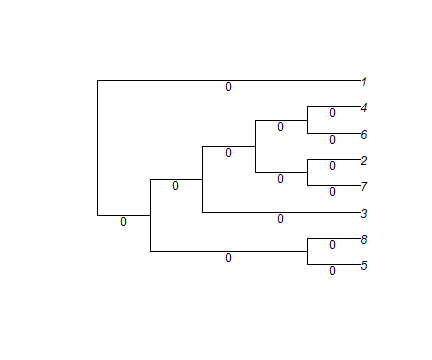

In [5]:
tree0 = readTopology(base);
plot(tree0, :R, showEdgeLength=true);
tree1 = readTopology(tree1);
plot(tree1, :R, showEdgeLength=true);
tree2 = readTopology(tree2);
plot(tree2, :R, showEdgeLength=true);
tree3 = readTopology(tree3);
plot(tree3, :R, showEdgeLength=true);
tree4 = readTopology(tree4);
plot(tree4, :R, showEdgeLength=true);
tree5 = readTopology(tree5);
plot(tree5, :R, showEdgeLength=true);

In [6]:
for i in 1:100
    simulate_trees(tree0, "data/nni/base_0_move_" * string(i) * ".jld", i)
    simulate_trees(tree1, "data/nni/base_1_move_" * string(i) * ".jld", i)
    simulate_trees(tree2, "data/nni/base_2_move_" * string(i) * ".jld", i)
    simulate_trees(tree3, "data/nni/base_3_move_" * string(i) * ".jld", i)
    simulate_trees(tree4, "data/nni/base_4_move_" * string(i) * ".jld", i)
    simulate_trees(tree5, "data/nni/base_5_move_" * string(i) * ".jld", i)
end

In [7]:
for k in 1:100
    trees = []
    for i in 1:6    
        path = "data/nni/base_" * string(i-1) *"_move_" * string(k) * ".jld"
        tree = jldopen(path, "r") do file
            read(file, "tree")
        end
        push!(trees, tree)
    end

    n = length(trees)
    result = zeros(n, n)

    for i in 2:n
        for j in  1:(i - 1)
            gt = ground_true(trees[i],trees[j])
            tree = vcat(trees[i],trees[j])
            tree = standardize_tree(tree)
            for k in 1:100
                pred_kmeans = kmeans_label(tree, 2) 
                m,x = accuracy(2, gt, pred_kmeans)
                if x > result[i,j]
                    result[i,j] = x
                    result[j,i] = x
                end
            end
        end
    end
    header = Vector(1:n)
    header = string.(header)
    CSV.write("data/nni/result/nni_reuslt_"* string(k) * ".csv", DataFrame(result, :auto), header = header);
end

In [23]:
using Clustering
using CSV
using DataFrames

In [25]:
trees = []
path = "data/8_diff_topo_1_1000_12.csv"
tree = CSV.read(path, DataFrame);
push!(trees, tree)
path = "data/8_diff_topo_7_1000_12.csv"
tree = CSV.read(path, DataFrame);
push!(trees, tree);

In [28]:
gt = ground_true(trees[1],trees[2])
tree = vcat(trees[1],trees[2])
tree = standardize_tree(tree)
R = fuzzy_cmeans(tree, 2, 2)

FuzzyCMeansResult: 2 clusters for 2000 points in 127 dimensions (converged in 35 iterations)

In [20]:
for i in 1:100
    trees = []
    for j in 1:15      
        path = "data/8_diff_topo_" * string(j) *  "_1000_" * string(i) * ".csv"
        tree = CSV.read(path, DataFrame);
        push!(trees, tree)
    end
    kmeans_matrix(trees, "data/kmeans_8_diff_topo_1000_" *string(i)* ".csv");
    # gmm_matrix(trees, "data/GMM_prob_8_topo_1000_" *string(i)* ".csv", "data/GMM_llpg_8_topo_1000_" *string(i)* ".csv");
end

LoadError: ArgumentError: provide a valid sink argument, like `using DataFrames; CSV.read(source, DataFrame)`